# Advanced Guide to `caskade`

The beginners guide layed out the basics of constructing simulators in `caskade`, now we will present the powerful capabilities and techniques that let you easily and efficiently perform complex analyses. The order of these techniques has no particular meaning, so you may search for points of interest or scan through for relevant sections. 

In [1]:
import torch
import caskade as ckd

## Break up a Param Tensor

Sometimes a `Param` value is naturally a multi-component tensor, but we only wish for part of it to be dynamic. This can be accomplished by creating new params and linking appropriately.

Original x tensor tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Rebuilt x tensor tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


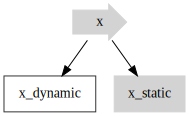

In [3]:
# This is the param we plan to use
x = ckd.Param("x", torch.arange(10)) # param has 10 elements
print("Original x tensor", x.value)

# These are sub params for the broken primary param
x_dynamic = ckd.Param("x_dynamic", torch.arange(3)) # want first three elements to be dynamic
x_dynamic.to_dynamic()
x_static = ckd.Param("x_static", torch.arange(3,10)) # want last seven elements to be static

# This rebuilds the full param from the broken params
x.value = lambda p: torch.cat((p["x_dynamic"].value, p["x_static"].value))
x.link(x_dynamic)
x.link(x_static)
print("Rebuilt x tensor", x.value)
x.graphviz()